<a href="https://colab.research.google.com/github/DivyanshRana1515/DL_Lab_500121856_Divyansh/blob/main/Exp_11_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
import zipfile
import io

uploaded = files.upload()

Saving archive (5).zip to archive (5).zip


In [5]:
# Cell 1: Unzip the uploaded dataset named archive 5 (search common names)
import os, zipfile, glob

candidates = [
    '/content/archive 5.zip',
    '/content/archive (5).zip',
    '/content/archive5.zip',
    '/content/archive.zip',
    '/content/archive (4).zip',
    '/content/archive (6).zip',
    '/content/flowers-recognition.zip',
    '/content/flowers.zip'
]

zip_path = None
for p in candidates:
    if os.path.exists(p):
        zip_path = p
        print("Found zip at:", p)
        break

if zip_path is None:
    raise FileNotFoundError("archive 5 zip not found. Upload it to /content and re-run this cell.")

extract_path = '/content/flowers_dataset'
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    print("Extracting", zip_path, "→", extract_path, " (this may take a minute)...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Extraction complete.")
else:
    print("Extraction folder already exists:", extract_path)

# Show top-level tree (up to 3 levels) to help identify where images are
def print_tree(root, max_levels=3):
    for root_dir, dirs, files in os.walk(root):
        level = root_dir.replace(root, '').count(os.sep)
        if level > max_levels:
            continue
        indent = '  ' * level
        print(f"{indent}{os.path.basename(root_dir)}/  ({len([f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))])} image files)")
        for d in sorted(dirs):
            print(f"{indent}  {d}/")
print_tree(extract_path, max_levels=3)

Found zip at: /content/archive (5).zip
Extracting /content/archive (5).zip → /content/flowers_dataset  (this may take a minute)...
Extraction complete.
flowers_dataset/  (0 image files)
  flowers/
  flowers/  (0 image files)
    daisy/
    dandelion/
    rose/
    sunflower/
    tulip/
    tulip/  (984 image files)
    rose/  (784 image files)
    sunflower/  (733 image files)
    dandelion/  (1052 image files)
    daisy/  (764 image files)


In [6]:
# Cell 2: If the extraction shows 0 files above, inspect the zip content listing
import zipfile
zip_path = zip_path  # from previous cell
with zipfile.ZipFile(zip_path, 'r') as z:
    all_names = z.namelist()
print("Total entries in zip:", len(all_names))
# print first 200 entries (or all if less)
for p in all_names[:200]:
    print(p)

Total entries in zip: 4317
flowers/daisy/100080576_f52e8ee070_n.jpg
flowers/daisy/10140303196_b88d3d6cec.jpg
flowers/daisy/10172379554_b296050f82_n.jpg
flowers/daisy/10172567486_2748826a8b.jpg
flowers/daisy/10172636503_21bededa75_n.jpg
flowers/daisy/102841525_bd6628ae3c.jpg
flowers/daisy/10300722094_28fa978807_n.jpg
flowers/daisy/1031799732_e7f4008c03.jpg
flowers/daisy/10391248763_1d16681106_n.jpg
flowers/daisy/10437754174_22ec990b77_m.jpg
flowers/daisy/10437770546_8bb6f7bdd3_m.jpg
flowers/daisy/10437929963_bc13eebe0c.jpg
flowers/daisy/10466290366_cc72e33532.jpg
flowers/daisy/10466558316_a7198b87e2.jpg
flowers/daisy/10555749515_13a12a026e.jpg
flowers/daisy/10555815624_dc211569b0.jpg
flowers/daisy/10555826524_423eb8bf71_n.jpg
flowers/daisy/10559679065_50d2b16f6d.jpg
flowers/daisy/105806915_a9c13e2106_n.jpg
flowers/daisy/10712722853_5632165b04.jpg
flowers/daisy/107592979_aaa9cdfe78_m.jpg
flowers/daisy/10770585085_4742b9dac3_n.jpg
flowers/daisy/10841136265_af473efc60.jpg
flowers/daisy/109

In [7]:
# Cell 3: Find the subfolder that contains most image files and set dataset_path automatically
import os

base = '/content/flowers_dataset'
best_folder = None
best_count = 0
for root, dirs, files in os.walk(base):
    cnt = sum(1 for f in files if f.lower().endswith(('.jpg','.jpeg','.png')))
    if cnt > best_count:
        best_count = cnt
        best_folder = root

if best_folder is None or best_count == 0:
    raise FileNotFoundError("No images found under /content/flowers_dataset. Check extraction or zip contents (run Cell 2).")
print("Using dataset folder:", best_folder)
print("Number of image files detected:", best_count)

dataset_path = best_folder  # use this path in subsequent cells

Using dataset folder: /content/flowers_dataset/flowers/dandelion
Number of image files detected: 1052


In [8]:
# Cell 4: Load all images (no labels needed for autoencoder)
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os, sys
from tqdm import tqdm

IMG_SIZE = 128
images = []
print("Loading images from:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    for fname in files:
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            p = os.path.join(root, fname)
            try:
                img = load_img(p, target_size=(IMG_SIZE, IMG_SIZE))
                arr = img_to_array(img).astype('float32') / 255.0
                images.append(arr)
            except Exception as e:
                # skip unreadable files
                continue

images = np.array(images)
print("Total images loaded:", images.shape)
if images.size == 0:
    raise RuntimeError("No images loaded. Check dataset_path and file formats.")

Loading images from: /content/flowers_dataset/flowers/dandelion
Total images loaded: (1052, 128, 128, 3)


In [9]:
# Cell 5: Build Encoder model
from tensorflow.keras import layers, models

latent_dim = 128

encoder_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="encoder_input")
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(latent_dim, activation='relu', name="latent_vector")(x)

encoder = models.Model(encoder_input, encoder_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,680 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 6: Build Decoder model
from tensorflow.keras import layers, models

decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(16*16*128, activation='relu')(decoder_input)
x = layers.Reshape((16,16,128))(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)   # 16->32
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)    # 32->64
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)    # 64->128
decoder_output = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same', name="reconstruction")(x)

decoder = models.Model(decoder_input, decoder_output, name="Decoder")
decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Conv2D)         │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,467,779 (17.04 MB)

 Trainable params: 4,467,779 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 7: Connect and compile Autoencoder
from tensorflow.keras import Model

autoencoder_input = encoder_input
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name="Autoencoder")

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 128)            │     4,287,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 128, 128, 3)    │     4,467,779 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,755,459 (33.40 MB)

 Trainable params: 8,755,459 (33.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 15
batch_size = 32

history = autoencoder.fit(
    images, images,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0876 - val_loss: 0.0660
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 0.0618 - val_loss: 0.0543
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 0.0505 - val_loss: 0.0429
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 0.0406 - val_loss: 0.0357
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 0.0354 - val_loss: 0.0350
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.0318 - val_loss: 0.0302
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 0.0290 - val_loss: 0.0288
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 0.0280 - val_loss: 0.0278
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 0.0257 - val_loss: 0.0268
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 0.0257 - val_loss: 0.0264
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 0.0243 - val_loss: 0.0253
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 0.0234 - val_lo

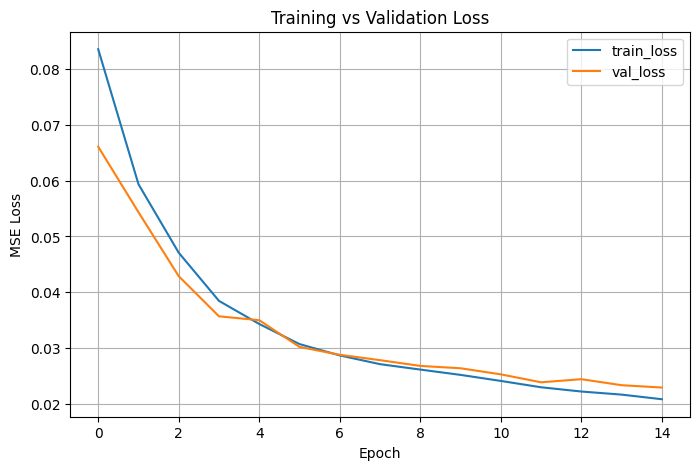

In [13]:
# Cell 9: Plot loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('Training vs Validation Loss'); plt.legend(); plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


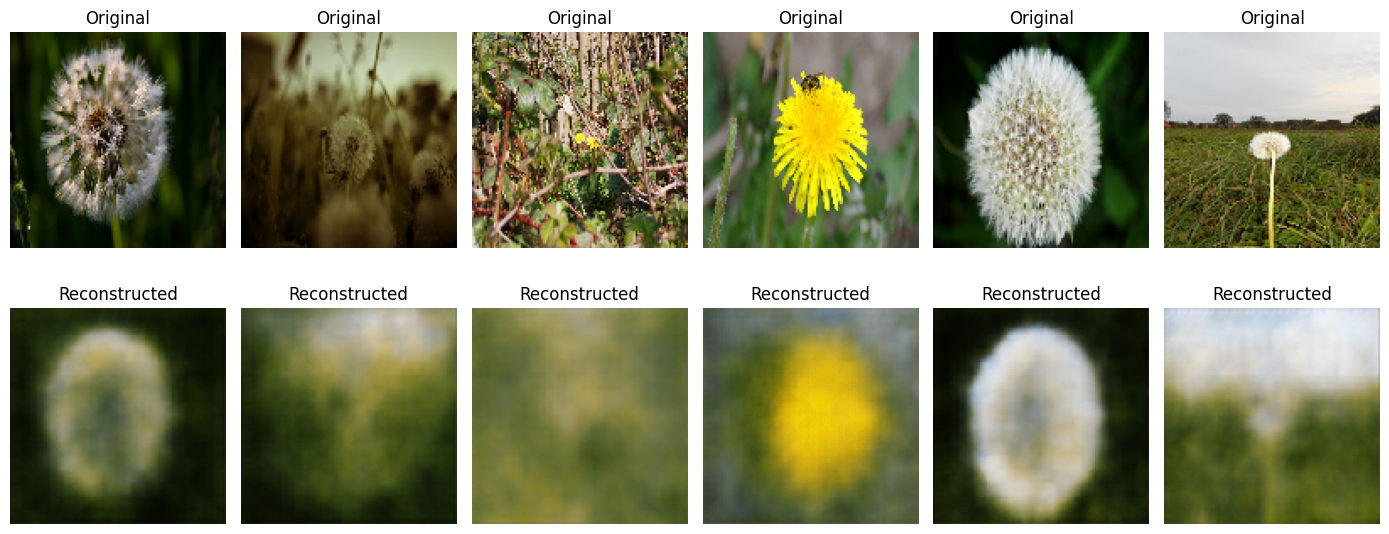

In [14]:
# Cell 10: Original vs reconstructed (N random samples)
import random, matplotlib.pyplot as plt
N = 6
idx = random.sample(range(len(images)), N)
sample = images[idx]
recon = autoencoder.predict(sample)

plt.figure(figsize=(14,6))
for i in range(N):
    plt.subplot(2, N, i+1); plt.imshow(sample[i]); plt.title("Original"); plt.axis('off')
    plt.subplot(2, N, i+1+N); plt.imshow(recon[i]); plt.title("Reconstructed"); plt.axis('off')
plt.tight_layout(); plt.show()

In [15]:
# Cell 11: Extract latent vectors for all images
latent_vectors = encoder.predict(images)
print("Latent vectors shape:", latent_vectors.shape)

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step
Latent vectors shape: (1052, 128)


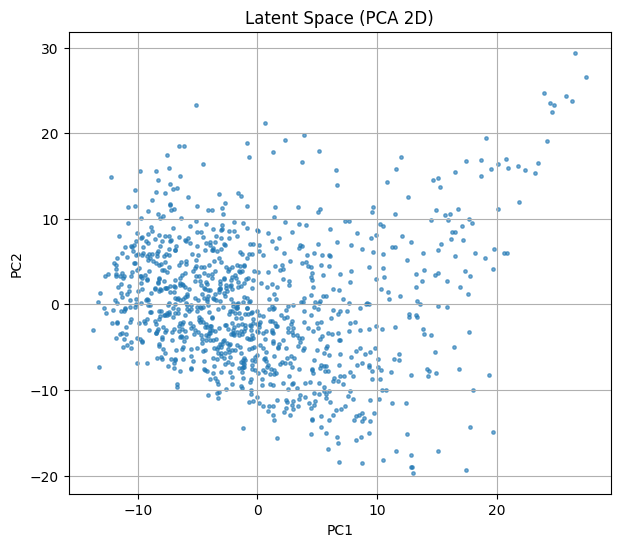

In [16]:
# Cell 12: PCA visualization of latent space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(7,6))
plt.scatter(latent_pca[:,0], latent_pca[:,1], s=6, alpha=0.6)
plt.title("Latent Space (PCA 2D)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True)
plt.show()

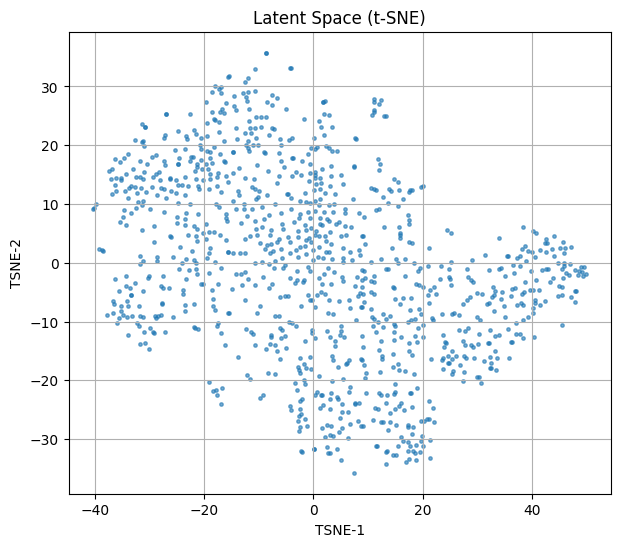

In [17]:
# Cell 13: t-SNE of latent space (optional; may take time)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(7,6))
plt.scatter(latent_tsne[:,0], latent_tsne[:,1], s=6, alpha=0.6)
plt.title("Latent Space (t-SNE)"); plt.xlabel("TSNE-1"); plt.ylabel("TSNE-2"); plt.grid(True)
plt.show()

In [18]:
# Cell 14: Compute MSE per image, print summary, save example pairs
import numpy as np, os, cv2
reconstructed_all = autoencoder.predict(images)
errors = np.mean((images.reshape(len(images), -1) - reconstructed_all.reshape(len(images), -1))**2, axis=1)

print("Images:", len(images))
print("Avg MSE:", errors.mean(), "Min:", errors.min(), "Max:", errors.max())

# Save first 10 side-by-side original|reconstructed
out_dir = "/content/recon_samples"
os.makedirs(out_dir, exist_ok=True)
K = min(10, len(images))
for i in range(K):
    orig = (images[i] * 255).astype('uint8')
    rec = (reconstructed_all[i] * 255).astype('uint8')
    both = np.hstack([orig, rec])
    cv2.imwrite(os.path.join(out_dir, f"sample_{i}.png"), cv2.cvtColor(both, cv2.COLOR_RGB2BGR))
print("Saved sample pairs to:", out_dir)

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 912ms/step
Images: 1052
Avg MSE: 0.020833846 Min: 0.0024341063 Max: 0.08657533
Saved sample pairs to: /content/recon_samples
